In [ ]:
import os
import pandas as pd

dataset_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'app','static','uploads', 'dataset.csv'))
result_path = os.path.realpath(os.path.join(os.path.dirname(__name__), '..', 'notebook', 'result'))

df_comments = pd.read_csv(dataset_path)
df_comments.tail(n=99)

In [ ]:
# Melihat jumlah data
df_comments['label'].value_counts()

#### Preprocessing

In [31]:
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

stemmer = StemmerFactory().create_stemmer()
stopword_factory = StopWordRemoverFactory()
combined_stopwords = set(stopword_factory.get_stop_words()).union(set(stopwords.words('english')))

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def preprocess_text(text):
    text = clean_text(text).lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in combined_stopwords]
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)


df_comments['preprocess'] = df_comments['comment'].apply(preprocess_text)
df_comments

,comment,label,preprocess
0,enka bgt d muka..ringan bgt.. klq o..y brasa b...,1,enka bgt mukaringan bgt klq oy brasa bratx klq...
1,Pakai krim malam dan pagi doang baru seminggu ...,1,pakai krim malam pagi doang baru minggu dah as...
2,Make up natural begitu malah lebih cantik ??,1,make natural malah lebih cantik
3,kakak lipstiknya pake apa bagus bangttt??,1,kakak lipstik pake apa bagus bangttt
4,Cantik bgt kmu beb tanpa makeup.. heheh ak lb...,1,cantik bgt kmu beb makeup heheh ak lbh suka km...
...,...,...,...
995,Sama q pkai daviena glowing series muka q jdi ...,-1,sama q pkai daviena glowing series muka q jdi ...
996,Aku pakai yg glowing tpi mukaku gak glowing hhhhh,-1,aku pakai yg glowing tpi muka gak glowing hhhhh
997,aku coba pake daviena bener� gak cocok make se...,-1,aku coba pake daviena bener gak cocok make har...
998,Mukak ku ancur pakek iniii??,-1,mukak ku ancur pakek iniii


#### Visual Polarisasi Kata

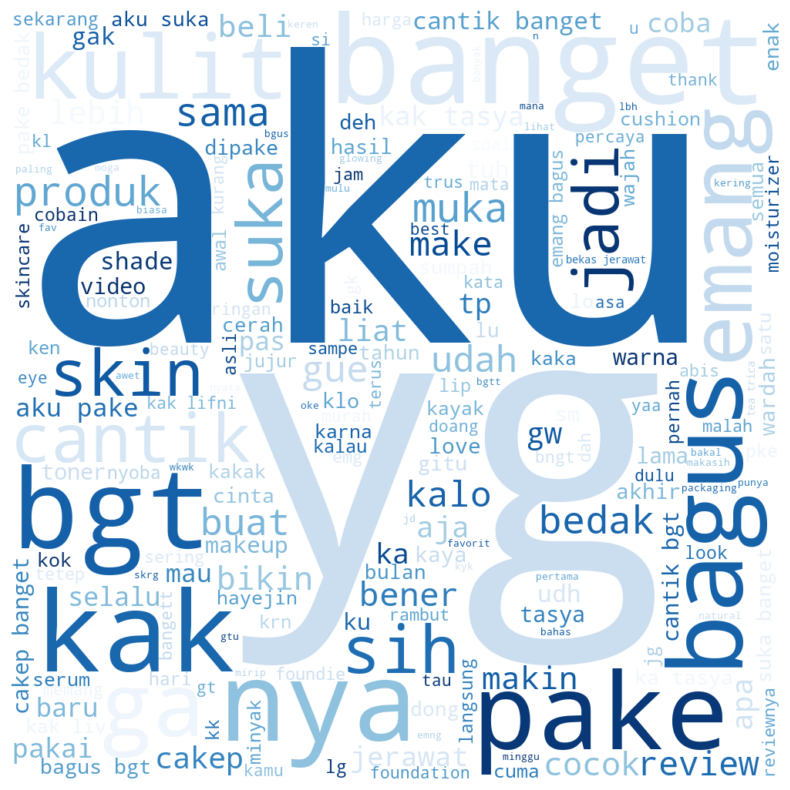

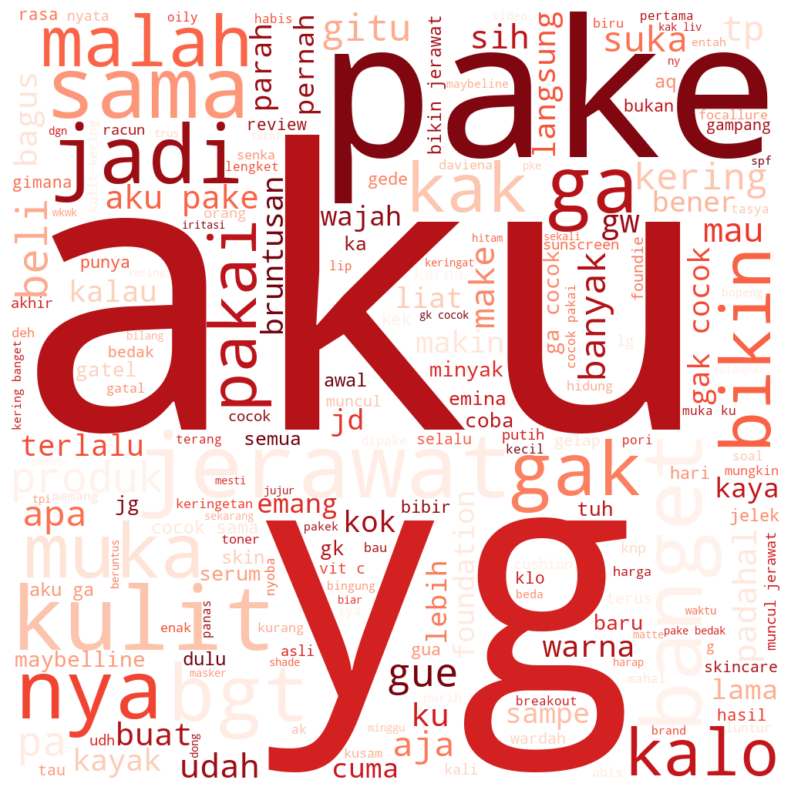

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# polarisasi positif
dataset_negatif = df_comments[df_comments['label'] == 1]
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# polarisasi negatif
dataset_negatif = df_comments[df_comments['label'] == -1]
dataset_negatif_text = ' '.join(word for word in dataset_negatif['preprocess'])
wc = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(dataset_negatif_text)
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

#### Bagi dataset menjadi 80% data training dan 20% data testing

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_comments['preprocess'], df_comments['label'], test_size=0.2, stratify=df_comments['label'], random_state=0)

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

vectorizer = TfidfVectorizer()
vectorizer.fit(df_comments['preprocess'])

terms = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

idf_df = pd.DataFrame(idf_values, index=terms, columns=["IDF"])

def compute_raw_tf(doc):
    words = doc.split()
    count = Counter(words)
    return count

raw_tf_dicts = [compute_raw_tf(doc) for doc in df_comments['preprocess']]
raw_tf_df = pd.DataFrame(raw_tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

def compute_tf(doc):
    words = doc.split()
    count = Counter(words)
    total_terms = len(words)
    tf = {term: count[term] / total_terms for term in count}
    return tf

tf_dicts = [compute_tf(doc) for doc in df_comments['preprocess']]
tf_df = pd.DataFrame(tf_dicts, index=[f'D{i+1}' for i in range(len(df_comments['preprocess']))]).T

raw_tf_df = raw_tf_df.fillna(0)
tf_df = tf_df.fillna(0)
idf_df = idf_df.fillna(0)

tf_norm_all = tf_df.sum(axis=1)

df_values = (raw_tf_df > 0).sum(axis=1)

final_df = pd.DataFrame(index=terms)
final_df['Terms'] = terms

final_df = final_df.join(raw_tf_df.add_prefix('TF')) 

final_df = final_df.join(tf_df.add_prefix('TFN')) 

final_df['TFNAll'] = tf_norm_all

final_df['DF'] = df_values

final_df['IDF'] = idf_df['IDF']

for doc in [f'D{i+1}' for i in range(len(df_comments['preprocess']))]:
    final_df[f'TFIDF_{doc}'] = final_df[f'TFN{doc}'] * final_df['IDF']

final_df = final_df.round(3)

final_df.to_csv(f'{result_path}/combined_tfidf_output_manual.csv', index=False)



C:\Users\muhak\AppData\Local\Temp\ipykernel_12720\1325248066.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'TFIDF_{doc}'] = final_df[f'TFN{doc}'] * final_df['IDF']
C:\Users\muhak\AppData\Local\Temp\ipykernel_12720\1325248066.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df[f'TFIDF_{doc}'] = final_df[f'TFN{doc}'] * final_df['IDF']
C:\Users\muhak\AppData\Local\Temp\ipykernel_12720\1325248066.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

In [35]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Prediksi Kelas Dataset

In [36]:
# Tampilkan hasil prediksi data test
from sklearn.svm import SVC

model = SVC(random_state=0, kernel='linear')

model.fit(X_train, y_train)
predict = model.predict(X_test)

print(f'aktual : {y_test}')
print(f'predict : {predict}')


[-1  1 -1  1  1 -1 -1  1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1  1
 -1 -1 -1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1
  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1  1 -1  1
 -1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1 -1  1 -1
  1  1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1 -1
 -1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1
  1  1  1  1 -1 -1  1  1]


#### Hitung Akurasi

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

# f1-score
print('F1-Score : ', f1_score(y_test, predict, pos_label=1))
# Accuracy
print('Accuracy : ', accuracy_score(y_test, predict))
# precision
print('Precision : ', precision_score(y_test, predict, pos_label=1))
# recall
print('Recall : ', recall_score(y_test, predict, pos_label=1))


# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
tn, fp, fn, tp


F1-Score :  0.8686868686868687
Accuracy :  0.87
Precision :  0.8775510204081632
Recall :  0.86


(np.int64(88), np.int64(12), np.int64(14), np.int64(86))